[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lisphilar/covid19-sir/HEAD?labpath=example%2F04_phase_dependent.ipynb)

# Phase-dependent SIR models
SIR-derived ODE models (SIR, SIR-D, SIR-F) assume that ODE parameter values are always constant. Can we apply this assumption to real data?

[Kaggle: COVID-19 data with SIR model](https://www.kaggle.com/code/lisphilar/covid-19-data-with-sir-model/notebook) concluded this was No - ODE parameter values change with phases - because measures taken by people changed the situation of COVID-19 outbreak actually. Term "phase" means a sequential dates in which the parameters of SIR-derived models are constant. To remove fluctuations from analysis, "time-dependent" should be avoided.

---

The first section will show the dynamics of phase-dependent SIR models with sample data. 

The Kaggle notebook also suggested detailed steps of applying phase-dependent SIR models to actual data. The second section demonstrates how to divide actual time-series data to phases (time-series segmentation with "S-R change point analysis"). The third section is to estimate ODE parameter values of phases ("ODE parameter estimation").

With fourth section, we will perform them with actual data of Tokyo/Japan as an example.

In [1]:
from copy import deepcopy
from pprint import pprint
import covsirphy as cs
import sympy
cs.__version__

'3.0.0'

## 1. Dynamics of phase-dependent SIR models
Using `Dynamics` class, we will simulate phase-dependent SIR model with sample data (two phase) as an example.

The 0th phase: 01Jan2022 - 28Feb2022, rho=0.2, sigma=0.075 (preset)  
The 1st phase: 01Mar2022 - 30Jun2022, **rho=0.4**, sigma=0.075

tau value: 1440 [min] (default)

### 1-1. Define the 0th phase
As the first step, define the 0th (initial) phase with preset ODE parameter values.

In [2]:
dyn = cs.Dynamics.from_sample(cs.SIRModel, date_range=("01Jan2022", "30Jun2022"), tau=1440)
# Show summary
dyn.summary()

,Start,End,Rt,rho,sigma,1/beta [day],1/gamma [day]
Phase,,,,,,,
0th,2022-01-01,2022-06-30,2.67,0.2,0.075,5,13


### 1-2. Define the 1st phase
Get the current settings of initial values of variables and ODE parameter values as a `pandas.DataFrame`. Then, edit it and register it to the instance.

In [3]:
before_df = dyn.register()
before_df

,Susceptible,Infected,Recovered,Fatal,rho,sigma
Date,,,,,,
2022-01-01,999000,1000,0,0,0.2,0.075
2022-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...
2022-06-26,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-06-27,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-06-28,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Without NAs:

In [4]:
before_df.dropna(how="all")

,Susceptible,Infected,Recovered,Fatal,rho,sigma
Date,,,,,,
2022-01-01,999000,1000,0,0,0.2,0.075


Edit the dataframe to set the ODE parameter values of the 1st phase.

In [5]:
setting_df = dyn.register()
setting_df.loc["01Mar2022", ["rho", "sigma"]] = [0.4, 0.075]
setting_df

,Susceptible,Infected,Recovered,Fatal,rho,sigma
Date,,,,,,
2022-01-01,999000,1000,0,0,0.2,0.075
2022-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...
2022-06-26,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-06-27,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-06-28,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Without NAs:

In [6]:
setting_df.dropna(how="all")

,Susceptible,Infected,Recovered,Fatal,rho,sigma
Date,,,,,,
2022-01-01,999000,1000,0,0,0.2,0.075
2022-03-01,<NA>,<NA>,<NA>,<NA>,0.4,0.075


Register the new settings. Because initial values on 01Mar2022 will be calculated with analytical solution of the 0th phase, they were not registered manually.

In [7]:
dyn.register(setting_df)
# Show summary
dyn.summary()

,Start,End,Rt,rho,sigma,1/beta [day],1/gamma [day]
Phase,,,,,,,
0th,2022-01-01,2022-02-28,2.67,0.2,0.075,5,13
1st,2022-03-01,2022-06-30,5.33,0.4,0.075,2,13


High-lightened:

In [8]:
dyn.summary().style.highlight_max(subset=["Rt", "rho", "1/beta [day]"])

,Start,End,Rt,rho,sigma,1/beta [day],1/gamma [day]
Phase,,,,,,,
0th,2022-01-01 00:00:00,2022-02-28 00:00:00,2.670000,0.200000,0.075000,5,13
1st,2022-03-01 00:00:00,2022-06-30 00:00:00,5.330000,0.400000,0.075000,2,13


With the same way, we can set additional phases, if necessary for your analysis.

### 1-3. Track ODE parameter values
Confirm the phase-dependent ODE parameter values and Rt (reproduction number) by plotting.

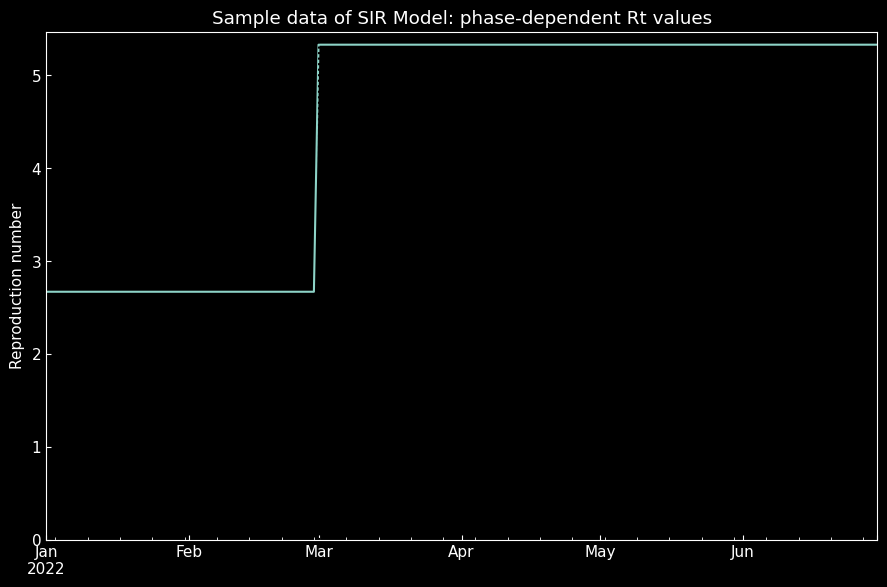

,Rt,rho,sigma,1/beta [day],1/gamma [day]
Date,,,,,
2022-02-27 00:00:00,2.670000,0.200000,0.075000,5,13
2022-02-28 00:00:00,2.670000,0.200000,0.075000,5,13
2022-03-01 00:00:00,5.330000,0.400000,0.075000,2,13
2022-03-02 00:00:00,5.330000,0.400000,0.075000,2,13


In [9]:
df = dyn.track()
cs.line_plot(
    df["Rt"],
    title=f"Sample data of {dyn.model_name}: phase-dependent Rt values",
    ylabel="Reproduction number",
    show_legend=False,
    v=dyn.start_dates()[1:]
)
df.loc["27Feb2022": "02Mar2022"].style.highlight_max(subset=["Rt", "rho", "1/beta [day]"])

### 1-4. Simulation
With `Dynamics().simulate()`, simulate the phase-dependent ODE model with numerical analysis of each phase. Because we did not specify the initial values on the start date of the 1st phase, simulated values on the 1st phase's start date will be used as the initial values of the 1st phase.

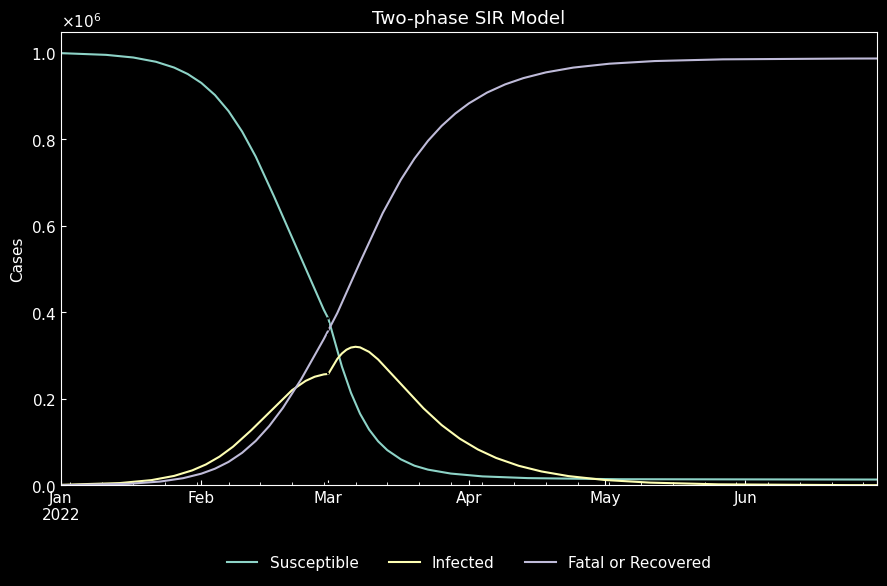

In [10]:
df = dyn.simulate(model_specific=True)
cs.line_plot(df, title=f"Two-phase {dyn.model_name}", v=dyn.start_dates()[1:])

When we need convert model-specific variables to model-free variables (Susceptible/Infected/Fatal/Recovered), we will set `model_specific=False` (default).
SIR model cannot separate "Fatal" cases and "Recovered" cases into different groups. Please use SIR-D model or SIR-F model if the following role is not acceptable for your analysis.

- "Fatal" is always equal to 0
- "Recovered" is equal to "Fatal or Recovered" of SIR model

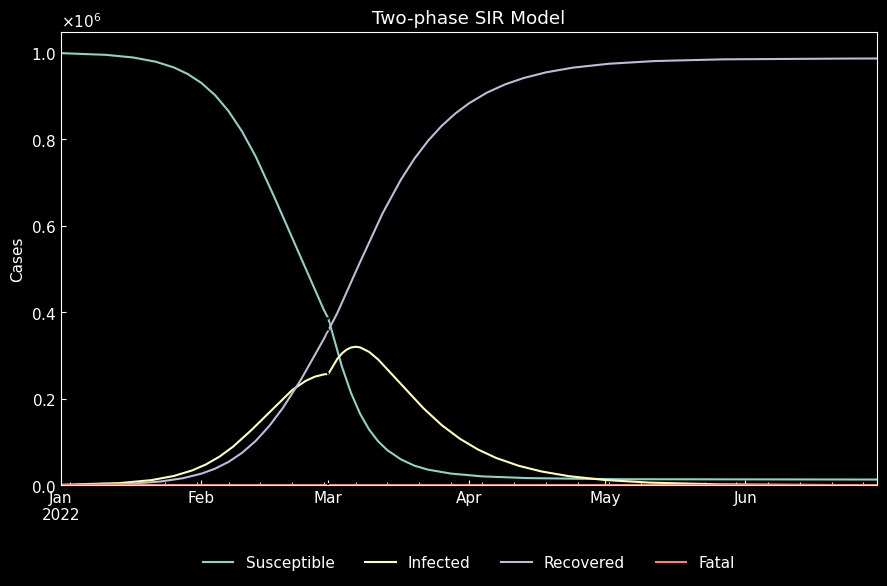

In [11]:
df = dyn.simulate(model_specific=False)
cs.line_plot(df, title=f"Two-phase {dyn.model_name}", v=dyn.start_dates()[1:])

### 1-5. Observable variables
Actually, observable variables are Population/Confirmed/Infected/Recovered. We can calculate Population and Confirmed as follows.

- Confirmed = Infected + Fatal + Recovered
- Population = Susceptible + Confirmed

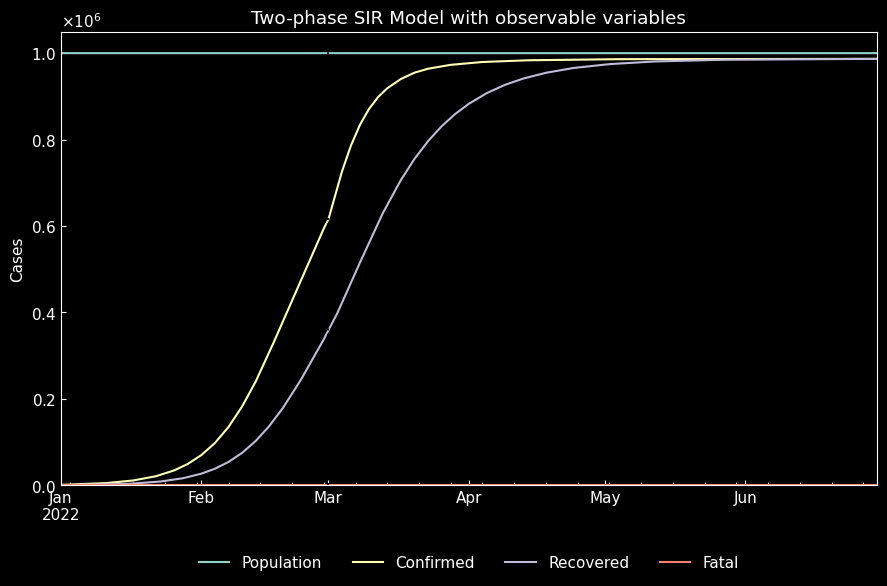

In [12]:
real_df = dyn.simulate(model_specific=False)
real_df["Confirmed"] = real_df[["Infected", "Fatal", "Recovered"]].sum(axis=1)
real_df["Population"] = real_df[["Susceptible", "Confirmed"]].sum(axis=1)
real_df = real_df.loc[:, ["Population", "Confirmed", "Recovered", "Fatal"]]
cs.line_plot(real_df, title=f"Two-phase {dyn.model_name} with observable variables", v=dyn.start_dates()[1:])

## 2. S-R change point analysis
S-R change point analysis (S-R trend analysis) is a technique to find the change points of phases with actual time-series data.

### 2-1. S-R plane
Author of the Kaggle Notebook considered S-R plane. This idea (S-R plane) is from [Balkew, Teshome Mogessie, "The SIR Model When S(t) is a Multi-Exponential Function." (2010).Electronic Theses and Dissertations.Paper 1747](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd). This is for simplest SIR model, but we can apply it to SIR-F model.

We will focus on the following equations of SIR-derived ODE models.

\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - \frac{\beta}{N} S I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
\end{align*}

When $I > 0$, this leads to
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}R}= - \frac{\beta}{N \gamma} S  \\
& \beta, \gamma, N: const.
\end{align*}

Because $S(0) = N$, $S$ is a function of $R$ as follows.

In [13]:
S = sympy.symbols("S", cls=sympy.Function)
N, R  = sympy.symbols("N R", positive=True)
beta, gamma = sympy.symbols(r"\beta \gamma", positive=True)
dS = - beta / (N * gamma) * S(R)
sr = sympy.dsolve(S(R).diff(R) - dS, hint="separable", ics={S(0): N})
sr

Eq(S(R), N*exp(-R*\beta/(N*\gamma)))

### 2-2. log(S) vs. R plane
Then,

In [14]:
sympy.Eq(sympy.simplify(sympy.log(sr.lhs)), sympy.simplify(sympy.log(sr.rhs)))

Eq(log(S(R)), log(N) - R*\beta/(N*\gamma))

Where $a=\cfrac{\beta}{N \gamma} \ (> 0)$,
\begin{align*}
& \log S_{(R)} = - a R + \log N  \\
& N: const.
\end{align*}

 $\log S$ decreases constantly with increase of $R$, when the records follow a SIR-derived model and the parameter values of the model are constant. Plot of $(x, y) = (R, \log S)$ shows a line.

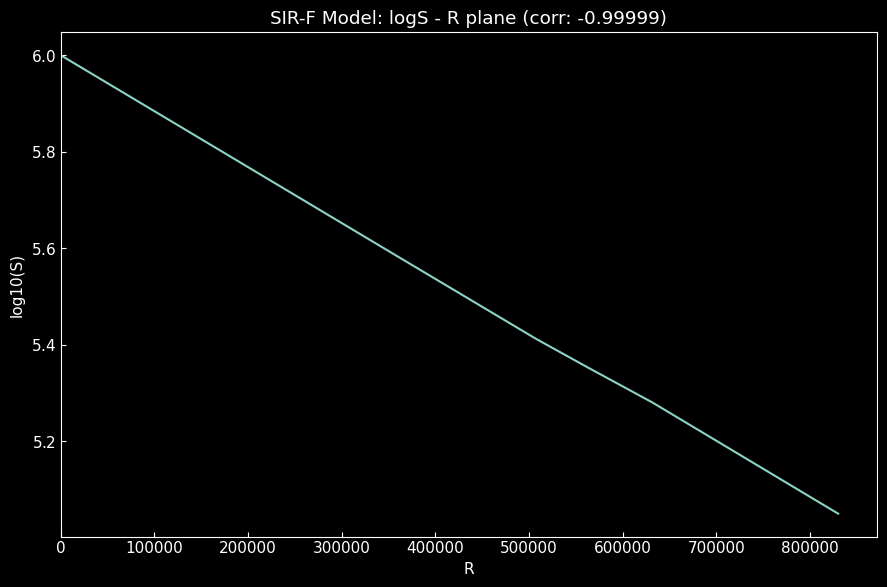

In [15]:
model = deepcopy(cs.SIRFModel)
sirf = model.from_sample()
solved_df = sirf.solve()
sr_df = model.sr(model.inverse_transform(solved_df))
corr = sr_df["log10(S)"].corr(sr_df["R"]).round(5)
cs.line_plot(
    sr_df.set_index("R"),
    title=f"{model.name()}: logS - R plane (corr: {corr})",
    xlabel="R", xlim=(0, None),
    ylabel="log10(S)", ylim=(None, None),
    show_legend=False
)

Initial values on the first date was set, but the summary shows just a phase with no set ODE parameter values.

Limitations:  
Because $a=\cfrac{\beta}{N \gamma}$, the changes of $\alpha_1$ and $\alpha_2$ of SIR-D/SIR-F model cannot be detected.

### 2-3. Plane of phase-dependent models
Correlation coefficient is about -1.0 when ODE parameter values are constant The slope of the line may change when the ODE parameter values are changed.

Sample data of phase-dependent SIR-F model is here.

In [16]:
dyn = cs.Dynamics.from_sample(cs.SIRFModel, date_range=("01Jan2022", "30Jun2022"))
# Set some phases by changing ODE parameter values
df = dyn.register()
parameters = ["theta", "kappa", "rho", "sigma"]
df.loc["18Feb2022", parameters] = [0.0002, 0.005, 0.40, 0.075]
df.loc["24Feb2022", parameters] = [0.0002, 0.005, 0.15, 0.075]
df.loc["01Mar2022", parameters] = [0.0002, 0.003, 0.40, 0.075]
df.loc["08Mar2022", parameters] = [0.0002, 0.005, 0.40, 0.150]
df.loc["15Mar2022", parameters] = [0.0000, 0.005, 0.40, 0.150]
dyn.register(df)
# Show summary
dyn.summary()[["Start", "End", "Rt", *parameters]].style.format(precision=4).background_gradient()

,Start,End,Rt,theta,kappa,rho,sigma
Phase,,,,,,,
0th,2022-01-01 00:00:00,2022-02-17 00:00:00,2.5000,0.0020,0.0050,0.2000,0.0750
1st,2022-02-18 00:00:00,2022-02-23 00:00:00,5.0000,0.0002,0.0050,0.4000,0.0750
2nd,2022-02-24 00:00:00,2022-02-28 00:00:00,1.8700,0.0002,0.0050,0.1500,0.0750
3rd,2022-03-01 00:00:00,2022-03-07 00:00:00,5.1300,0.0002,0.0030,0.4000,0.0750
4th,2022-03-08 00:00:00,2022-03-14 00:00:00,2.5800,0.0002,0.0050,0.4000,0.1500
5th,2022-03-15 00:00:00,2022-06-30 00:00:00,2.5800,0.0000,0.0050,0.4000,0.1500


Dynamics:

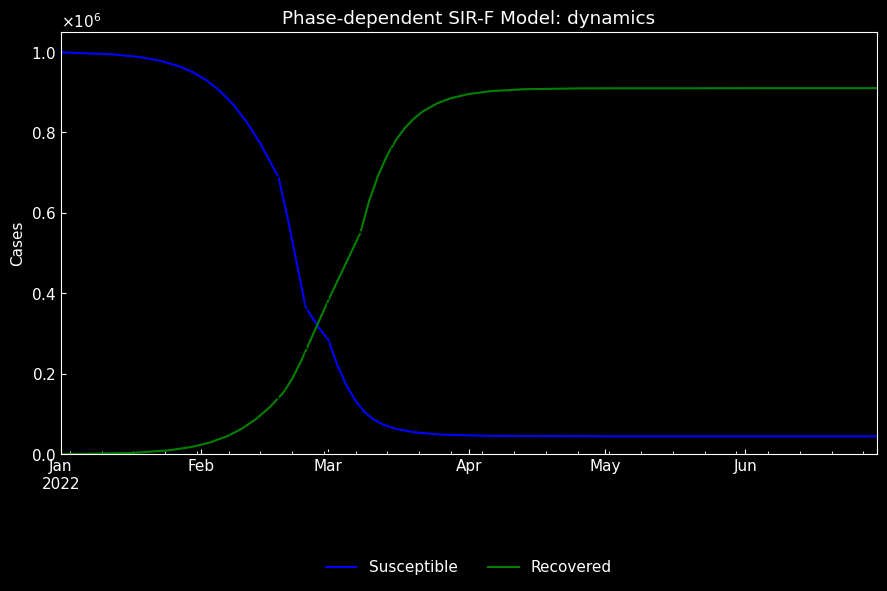

In [17]:
model = deepcopy(cs.SIRFModel)
df = dyn.simulate(model_specific=True)
cs.line_plot(
    df[["Susceptible", "Recovered"]],
    color_dict={"Susceptible": "blue", "Recovered": "green"},
    title=f"Phase-dependent {model.name()}: dynamics",
    v=dyn.start_dates()[1:],
    bbox_to_anchor=(0.5, -0.3), bbox_loc="lower center",
)

Plot of $(R, \log _{10} S)$: with vertical lines on change points (= start dates of phases 1st - last):

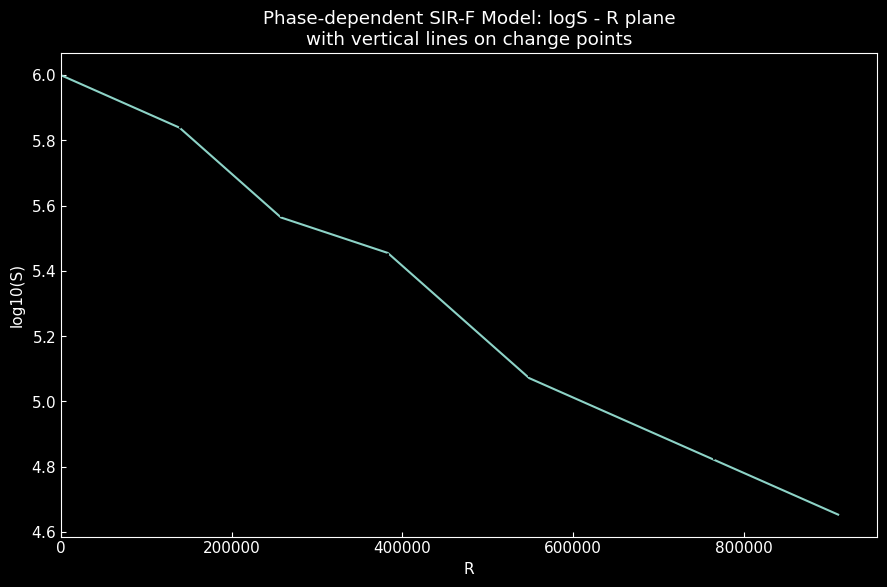

In [18]:
model = deepcopy(cs.SIRFModel)
# Get (R, log10S)
sr_df = model.sr(dyn.simulate())
# Plotting
cs.line_plot(
    sr_df.set_index("R"),
    title=f"Phase-dependent {model.name()}: logS - R plane\nwith vertical lines on change points",
    xlabel="R", xlim=(0, None),
    ylabel="log10(S)", ylim=(None, None),
    show_legend=False,
    v=[sr_df.loc[d, "R"] for d in dyn.start_dates()[1:]],
)

With the plotting, we can confirm most of the change points (except for 5th - 6th: difficult because the change was for $\alpha_1$).

### 2.4 Time-series segmentation
The previous sub-sections demonstrated that change points of S-R trend suggest change points of phases. Here, we will detect the change points of S-R trend with `Dynamics().detect()` via `Dynamics.segment()`. They uses [ruptures library: change point detection in Python](https://github.com/deepcharles/ruptures) for off-line change point detection.

We will prepare a dataset which has the 0th - 5th phase.

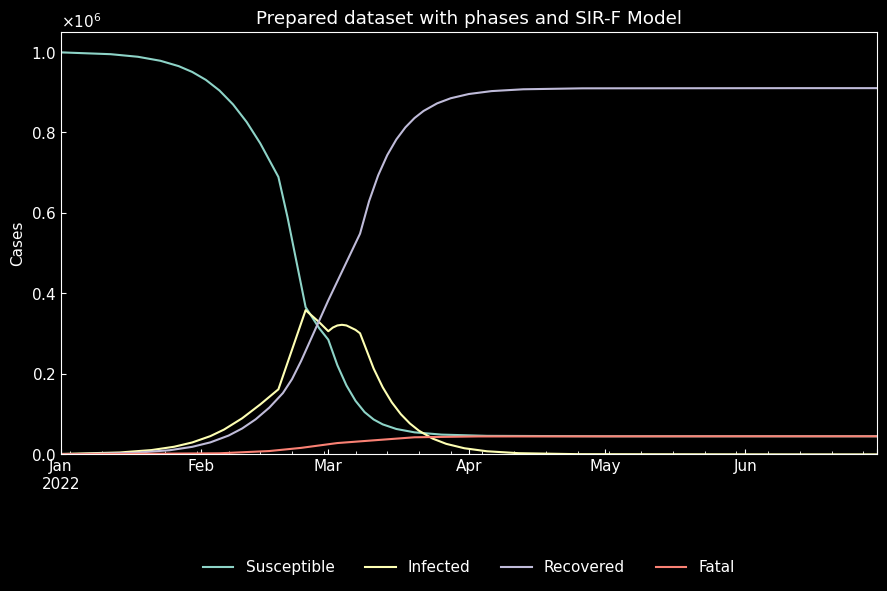

In [19]:
dyn = cs.Dynamics.from_sample(cs.SIRFModel, date_range=("01Jan2022", "30Jun2022"), tau=1440)
# Set some phases by changing ODE parameter values
df = dyn.register()
parameters = ["theta", "kappa", "rho", "sigma"]
df.loc["18Feb2022", parameters] = [0.0002, 0.005, 0.40, 0.075]
df.loc["24Feb2022", parameters] = [0.0002, 0.005, 0.15, 0.075]
df.loc["01Mar2022", parameters] = [0.0002, 0.003, 0.40, 0.075]
df.loc["08Mar2022", parameters] = [0.0002, 0.005, 0.40, 0.150]
df.loc["15Mar2022", parameters] = [0.0000, 0.005, 0.40, 0.150]
dyn.register(df)
# Simulation
sim_df = dyn.simulate(model_specific=False)
cs.line_plot(
    sim_df,
    title=f"Prepared dataset with phases and {dyn.model_name}",
    bbox_to_anchor=(0.5, -0.3),
)

Create an instance of `Dynamics` with the prepared data. Note that the instance does not know the change points of phases.

In [20]:
dyn_sim = cs.Dynamics.from_data(model=cs.SIRFModel, data=sim_df, tau=None, name="Sample data")
# Show summary
display(dyn_sim.summary())

,Start,End
Phase,,
0th,2022-01-01,2022-06-30


`Dynamics().detect()` performs S-R change point analysis (trend analysis) and show the trend on S-R plane. Dot lines are the change points of phases.

With `algo` argument, we can select the algorithm and models to detect the change points from “Binseg-normal” (default), “Pelt-rbf”, “Binseg-rbf”, “BottomUp-rbf”, “BottomUp-normal”. Please refer to [the documentation of ruptures library](https://centre-borelli.github.io/ruptures-docs/).

Additionally, we can specify the minimum size of phases with argument `min_size=7` (as default, [days]).

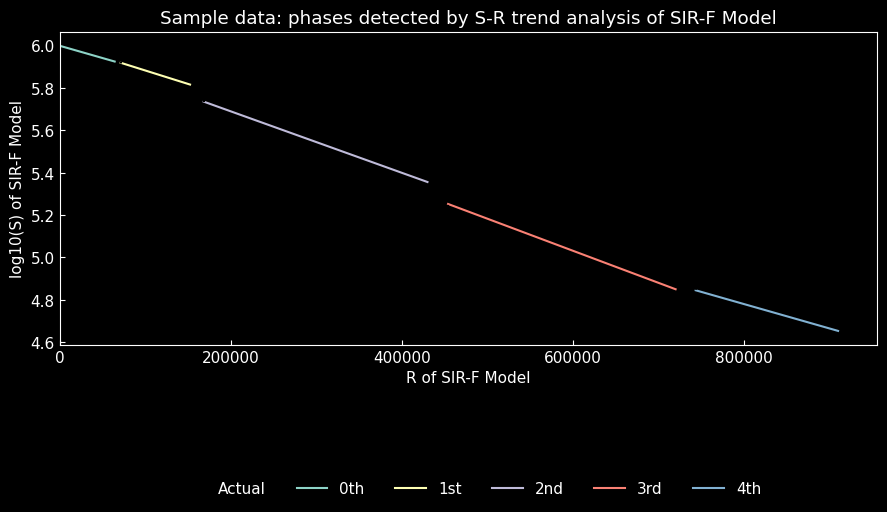

[Timestamp('2022-02-11 00:00:00'),
 Timestamp('2022-02-20 00:00:00'),
 Timestamp('2022-03-04 00:00:00'),
 Timestamp('2022-03-14 00:00:00')]


,Actual,0th,1st,2nd,3rd,4th,Fitted
R,,,,,,,
0,5.999565,5.999569,NaN,NaN,NaN,NaN,5.999569
80,5.999473,5.999476,NaN,NaN,NaN,NaN,5.999476
169,5.999369,5.999373,NaN,NaN,NaN,NaN,5.999373
271,5.999252,5.999255,NaN,NaN,NaN,NaN,5.999255
385,5.999120,5.999123,NaN,NaN,NaN,NaN,5.999123
...,...,...,...,...,...,...,...
910075,4.652981,NaN,NaN,NaN,NaN,4.652989,4.652989
910076,4.652981,NaN,NaN,NaN,NaN,4.652988,4.652988
910077,4.652981,NaN,NaN,NaN,NaN,4.652986,4.652986


In [21]:
points, fit_df = dyn_sim.detect(algo="Binseg-rbf", min_size=7)
# List of change points
pprint(points)
# Plotted values
display(fit_df)

Note that detected phases are un-registered to the instance.

In [22]:
dyn_sim.summary()

,Start,End
Phase,,
0th,2022-01-01,2022-06-30


To perform time-series segmentation with S-R trend analysis, we will use `Dynamics().segment()`, which accepts all keyword arguments of `Dynamics().detect()`.

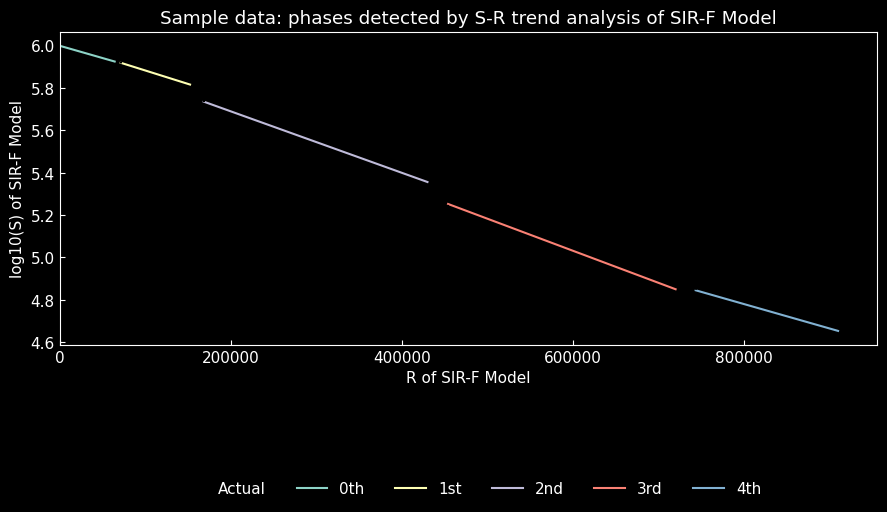

,Start,End
Phase,,
0th,2022-01-01,2022-02-10
1st,2022-02-11,2022-02-19
2nd,2022-02-20,2022-03-03
3rd,2022-03-04,2022-03-13
4th,2022-03-14,2022-06-30


In [23]:
dyn_sim.segment(algo="Binseg-rbf", min_size=7)
# Show summary
dyn_sim.summary()

If we need to add new change points or over-write change points, we will use `Dynamics().segment(points=<list>, overwrite=<bool>)`.

In [24]:
# Over-write
dyn_sim.segment(points=["01Mar2022", "01Jun2022"], overwrite=True)
# Add
dyn_sim.segment(points=["01May2022"], overwrite=False)
# Show summary
dyn_sim.summary()

,Start,End
Phase,,
0th,2022-01-01,2022-02-28
1st,2022-03-01,2022-04-30
2nd,2022-05-01,2022-05-31
3rd,2022-06-01,2022-06-30


## 3. ODE parameter estimation
This section demonstrates how to estimate tau value (constant for all phases) and the ODE parameter values of phases.

### 3.1 Preparation
Create an `Dynamics()` instance which has a dataset with 6 phases (the 0th - 5th). The instance knows change points, but does not know tau value and ODE parameter values.

Create dataset.

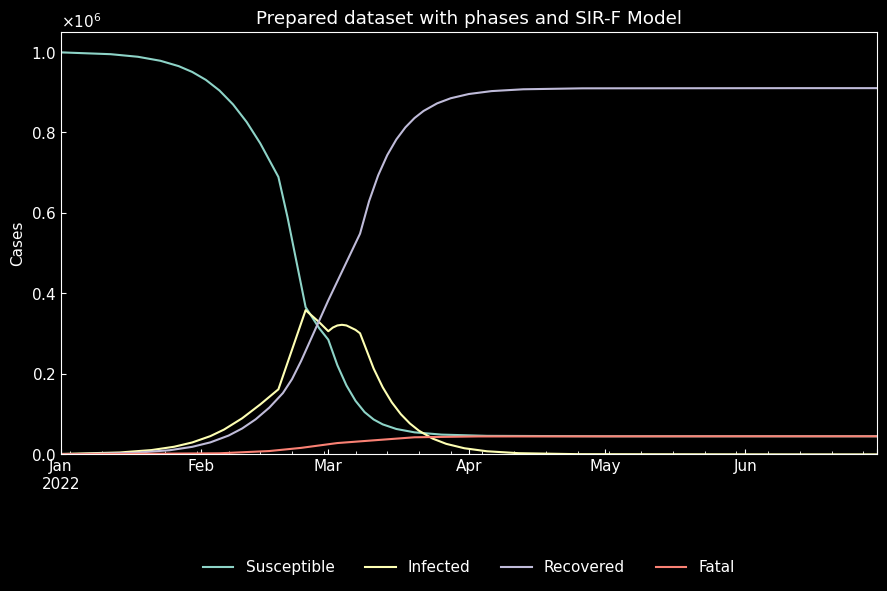

In [25]:
dyn = cs.Dynamics.from_sample(cs.SIRFModel, date_range=("01Jan2022", "30Jun2022"), tau=1440)
# Set some phases by changing ODE parameter values
df = dyn.register()
parameters = ["theta", "kappa", "rho", "sigma"]
df.loc["18Feb2022", parameters] = [0.0002, 0.005, 0.40, 0.075]
df.loc["24Feb2022", parameters] = [0.0002, 0.005, 0.15, 0.075]
df.loc["01Mar2022", parameters] = [0.0002, 0.003, 0.40, 0.075]
df.loc["08Mar2022", parameters] = [0.0002, 0.005, 0.40, 0.150]
df.loc["15Mar2022", parameters] = [0.0000, 0.005, 0.40, 0.150]
dyn.register(df)
# Simulation
sim_df = dyn.simulate(model_specific=False)
cs.line_plot(
    sim_df,
    title=f"Prepared dataset with phases and {dyn.model_name}",
    bbox_to_anchor=(0.5, -0.3),
)

Create `Dynamics()` instance.

In [26]:
dyn_est = cs.Dynamics.from_data(cs.SIRFModel, data=sim_df, tau=None, name="Sample data")
dyn_est.segment(points=["18Feb2022", "24Feb2022", "01Mar2022", "08Mar2022", "15Mar2022"])
# Show tau value
print(f"Tau value [min]: {dyn_est.tau or 'un-set'}")
# Show summary
display(dyn_est.summary())

Tau value [min]: un-set


,Start,End
Phase,,
0th,2022-01-01,2022-02-17
1st,2022-02-18,2022-02-23
2nd,2022-02-24,2022-02-28
3rd,2022-03-01,2022-03-07
4th,2022-03-08,2022-03-14
5th,2022-03-15,2022-06-30


### 3.2 Tau estimation
Before ODE parameter estimation, we need to select tau value [min]. Tau value is expected to be constant for all phases because tau value is a parameter used to convert actual time (with unit [min]) to time steps (without units) from divisors of 1440).

`Dynamics().estimate_tau(metric="RMSLE", q=0.5, digits=None, n_jobs=None)` (as default) sets the best tau value for the registered data, estimating ODE parameters with quantiles.

Arguments:

* metric (str): metric name for scoring when selecting best tau value
* q (float): the quantiles to compute, values between (0, 1)
* digits (int or None): effective digits of ODE parameter values or None (skip rounding)
* n_jobs (int or None): the number of parallel jobs or None (CPU count)

Metrics (selectable candidates of `metric`):

* ME: maximum residual error
* MAE: mean absolute error
* MSE: mean square error
* MSLE: mean squared logarithmic error
* MAPE: mean absolute percentage error
* RMSE: root mean squared error
* RMSLE: root mean squared logarithmic error
* R2: the coefficient of determination


For example, RMSLE score will be calculated with the following equation.
\begin{align*}
\mathrm{RMSLE} = \sqrt{\cfrac{1}{n}\sum_{i=1}^{n}(log_{10}(A_{i} + 1) - log_{10}(P_{i} + 1))^2}
\end{align*}
Where $A$ is the observed (actual) values, $P$ is estimated (predicted) values. Variables are $S (i=1), I (i=2), R (i=3)\ \mathrm{and}\ F (i=n=4)$ for SIR-F model. When RMSLE score is low, hyperparameter estimation is highly accurate. Please refer to external sites, including [Medium: What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a).

Tau value [min]: 48


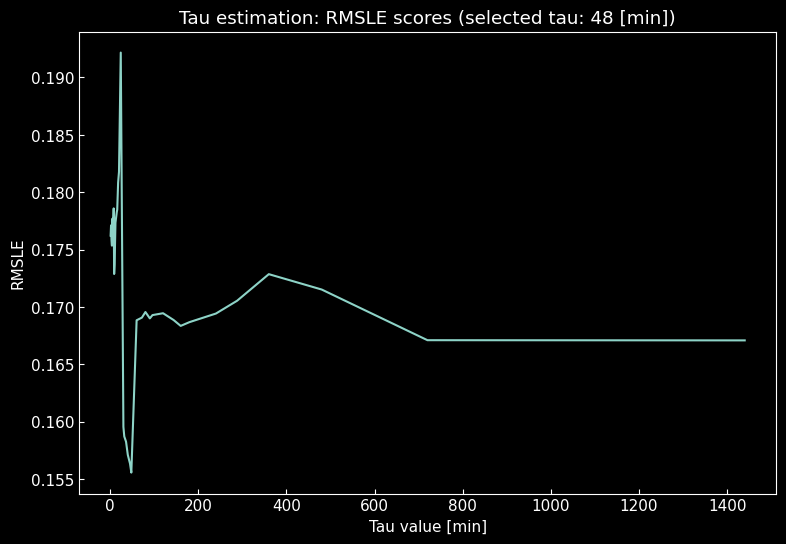

In [27]:
metric = "RMSLE"
tau, score_df = dyn_est.estimate_tau(metric=metric)
print(f"Tau value [min]: {dyn_est.tau or 'un-set'}")
score_df.plot.line(
    title=f"Tau estimation: {metric} scores (selected tau: {tau} [min])",
    xlabel="Tau value [min]", ylabel=metric, legend=False
);

### 3.3 ODE parameter estimation
`Dynamics().estimate_params(metric="RMSLE", digits=None, n_jobs=None, **kwargs)` (as default) sets ODE parameter values optimized for the registered data with hyperparameter optimization using [Optuna library](https://github.com/optuna/optuna).

Arguments of `Dynamics().estimate_params`:

* metric (str): metric name for scoring when optimizing ODE parameter values of phases
* digits (int or None): effective digits of ODE parameter values or None (skip rounding)
* n_jobs (int or None): the number of parallel jobs or None (CPU count)
* **kwargs: keyword arguments of optimization
    * quantiles (tuple(int, int)): quantiles to cut parameter range, like confidence interval, (0.1, 0.9) as default
    * timeout (int): timeout of optimization, 180 as default
    * timeout_iteration (int): timeout of one iteration, 1 as default
    * tail_n (int): the number of iterations to decide whether score did not change for the last iterations, 4 as default
    * allowance (tuple(float, float)): the allowance of the max predicted values, (0.99, 1.01) as default
    * pruner (str): kind of pruner (hyperband, median, threshold or percentile), "threshold" as default
    * upper (float): works for "threshold" pruner, intermediate score is larger than this value, it prunes, 0.5 as default
    * percentile (float): works for "Percentile" pruner, the best intermediate value is in the bottom percentile among trials, it prunes, 50 as default
    * constant_liar (bool): whether use constant liar to reduce search effort or not, False as default

In [28]:
est_df = dyn_est.estimate_params()
# Show RMSLE scores pf phases
est_df = est_df.drop_duplicates()
est_df.index.name = "Start"
display(est_df)

  0%|          | 0/6 [00:00<?, ?it/s]

,theta,kappa,rho,sigma,RMSLE,Trials,Runtime
Start,,,,,,,
2022-03-15,0.116628,0.000084,0.009303,0.004875,0.058414,78,0 min 5 sec
2022-02-24,0.000029,0.000212,0.006513,0.003169,0.037871,234,0 min 10 sec
2022-01-01,0.000422,0.000174,0.006641,0.002469,0.007857,264,0 min 15 sec
2022-03-08,0.000302,0.000205,0.016927,0.00611,0.061443,364,0 min 16 sec
2022-03-01,0.000331,0.000116,0.016227,0.002908,0.054571,536,0 min 24 sec
2022-02-18,0.000118,0.000189,0.015258,0.002784,0.048519,659,0 min 29 sec


In [29]:
dyn_est.summary()

,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Phase,,,,,,,,,,,
0th,2022-01-01,2022-02-17,2.51,0.000422,0.000174,0.006641,0.002469,0.0,191,5,13
1st,2022-02-18,2022-02-23,5.13,0.000118,0.000189,0.015258,0.002784,0.0,176,2,12
2nd,2022-02-24,2022-02-28,1.93,0.000029,0.000212,0.006513,0.003169,0.0,157,5,11
3rd,2022-03-01,2022-03-07,5.36,0.000331,0.000116,0.016227,0.002908,0.0,287,2,11
4th,2022-03-08,2022-03-14,2.68,0.000302,0.000205,0.016927,0.00611,0.0,163,2,5
5th,2022-03-15,2022-06-30,1.66,0.116628,0.000084,0.009303,0.004875,0.117,396,4,7


## 4. With actual data
This section demonstrates how to divide actual time-series data with phases ("S-R change point analysis") and to estimate ODE parameter values of phases ("ODE parameter estimation").

### 4-1. Data preparation
Prepare actual prefecture-level time-series data in Japan for demonstration.

Download the dataset.

In [30]:
eng = cs.DataEngineer()
eng.download(country=None, databases=["japan", "covid19dh"]);

Data cleaning, transformation, subsetting, complement.

In [31]:
eng.clean()
eng.transform()
actual_df, status, _ = eng.subset(geo=("Japan",), variables="SIRF", complement=True)
print(status)
actual_df.tail()

monotonic increasing complemented confirmed data and 
monotonic increasing complemented fatal data and 
fully complemented recovered data


,Susceptible,Infected,Recovered,Fatal
Date,,,,
2023-05-04,92738009.0,183209,33533260,74622
2023-05-05,92732198.0,177397,33544864,74641
2023-05-06,92725964.0,171546,33556937,74653
2023-05-07,92711524.0,175456,33567458,74662
2023-05-08,92702197.0,174762,33577464,74677


Plotting: removed "Susceptible" from the figure because "Susceptible" >> max("Infected", "Infected", "Recovered").

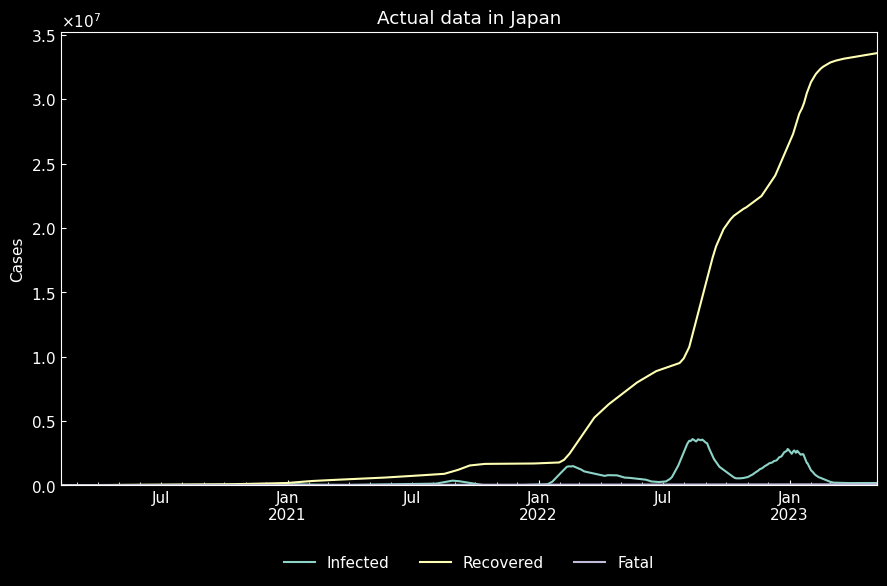

In [32]:
cs.line_plot(actual_df.drop("Susceptible", axis=1), "Actual data in Japan")

With the data, create an instance of `Dynamics` class.

In [33]:
dyn_act = cs.Dynamics.from_data(model=cs.SIRFModel, data=actual_df, name="Japan")
# Show registered values
dyn_act.register().tail()

,Susceptible,Infected,Recovered,Fatal,theta,kappa,rho,sigma
Date,,,,,,,,
2023-05-04,92738009,183209,33533260,74622,<NA>,<NA>,<NA>,<NA>
2023-05-05,92732198,177397,33544864,74641,<NA>,<NA>,<NA>,<NA>
2023-05-06,92725964,171546,33556937,74653,<NA>,<NA>,<NA>,<NA>
2023-05-07,92711524,175456,33567458,74662,<NA>,<NA>,<NA>,<NA>
2023-05-08,92702197,174762,33577464,74677,<NA>,<NA>,<NA>,<NA>


In [34]:
# Show summary
dyn_act.summary()

,Start,End
Phase,,
0th,2020-02-06,2023-05-08


### 4-2. Time-series segmentation
With `Dynamics.segment()`, we will apply S-R change point analysis (trend analysis) to the prepared actual data.

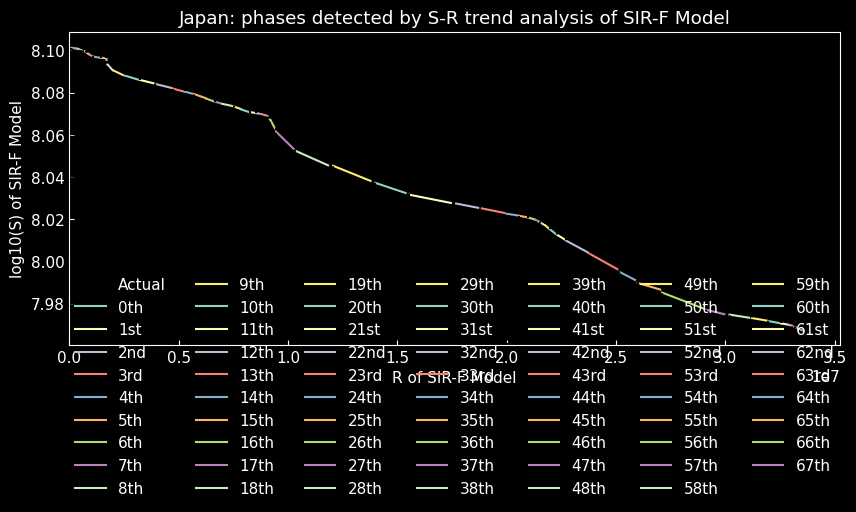

Phase,0th,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,...,58th,59th,60th,61st,62nd,63rd,64th,65th,66th,67th
Start,2020-02-06,2020-08-11,2020-11-17,2020-12-25,2021-01-17,2021-02-11,2021-04-04,2021-04-22,2021-05-07,2021-05-25,...,2023-01-24,2023-01-31,2023-02-08,2023-02-20,2023-03-01,2023-03-12,2023-03-28,2023-04-08,2023-04-19,2023-04-28
End,2020-08-10,2020-11-16,2020-12-24,2021-01-16,2021-02-10,2021-04-03,2021-04-21,2021-05-06,2021-05-24,2021-07-01,...,2023-01-30,2023-02-07,2023-02-19,2023-02-28,2023-03-11,2023-03-27,2023-04-07,2023-04-18,2023-04-27,2023-05-08


In [35]:
dyn_act.segment();
# Show summary
dyn_act.summary().T

### 4-3. Parameter estimation
`Dynamics().estimate(**kwargs)` performs `Dynamics().estimate_tau()` and `Dynamics().estimate_params()` in order.

In [36]:
dyn_act.estimate()
print(f"Tau value [min]: {dyn_act.tau or 'un-set'}")
# Show summary
dyn_act.summary()

  0%|          | 0/68 [00:00<?, ?it/s]

Tau value [min]: 15


,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Phase,,,,,,,,,,,
0th,2020-02-06,2020-08-10,1.41,0.001217,0.000078,0.00133,0.000861,0.001,134,8,12
1st,2020-08-11,2020-11-16,0.9,0.001814,0.000003,0.000782,0.000861,0.002,3104,13,12
2nd,2020-11-17,2020-12-24,1.75,0.008264,0.000004,0.000704,0.000396,0.008,2509,15,26
3rd,2020-12-25,2021-01-16,1.5,0.000054,0.000008,0.000839,0.00055,0.0,1251,12,19
4th,2021-01-17,2021-02-10,0.69,0.006528,0.000008,0.000381,0.000541,0.007,1229,27,19
...,...,...,...,...,...,...,...,...,...,...,...
63rd,2023-03-12,2023-03-27,1.67,0.001628,0.000002,0.000665,0.000395,0.002,5153,16,26
64th,2023-03-28,2023-04-07,0.65,0.00763,0.000002,0.000647,0.000992,0.008,4175,16,10
65th,2023-04-08,2023-04-18,1.47,0.000063,0.000002,0.000829,0.000563,0.0,5143,13,19


### 4-4. Accuracy evaluation
Compare the simulated results and actual records, and evaluate the differences.

Arguments:
- date_range (tuple of (str or pandas.Timestamp or None) or None): range of dates to evaluate or None (the first and the last date)
- metric (str): metric to evaluate the difference, "RMSLE" as default
- display (bool): whether display figure of comparison or not
- kwargs: keyword arguments of `covsirphy.compare_plot()`

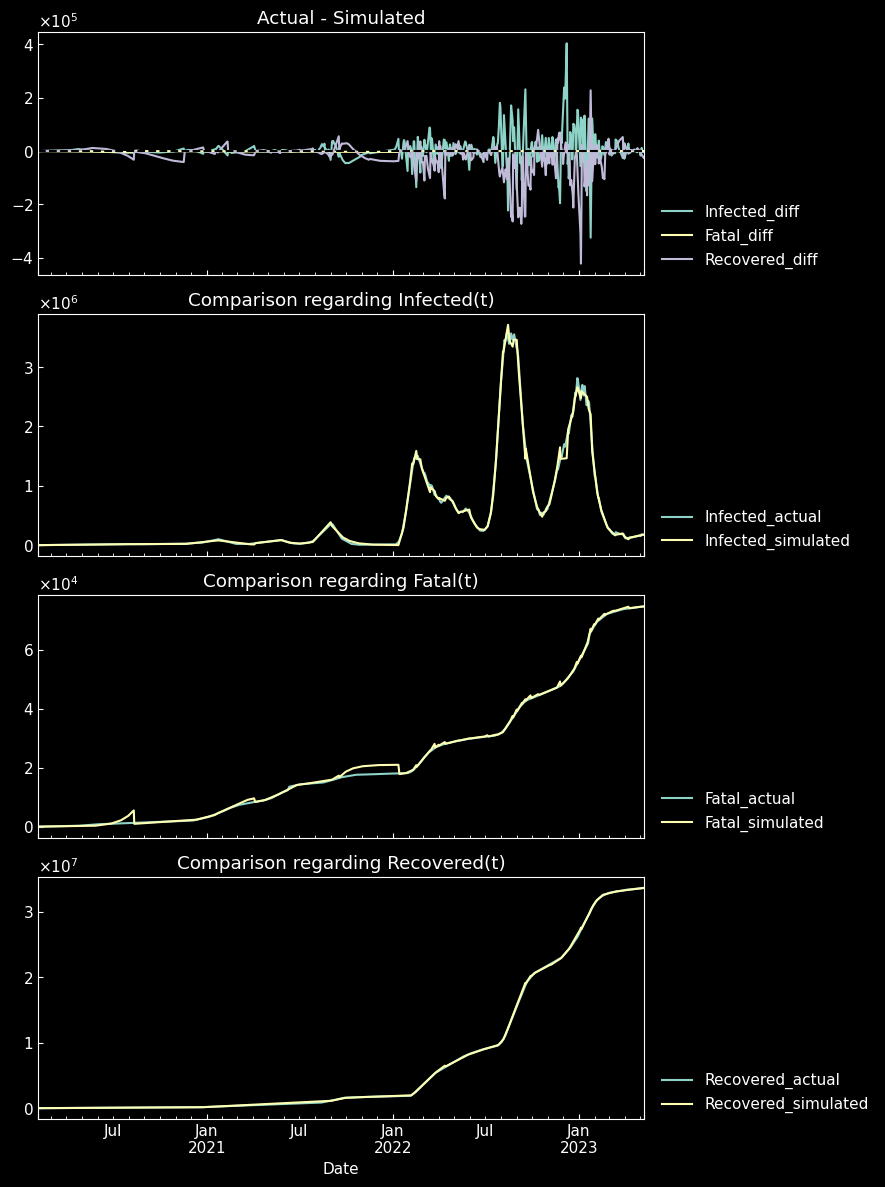

RMSLE: 0.5566 (overall score for time-series segmentation, tau estimation and ODE parameter estimation)


In [37]:
metric = "RMSLE"
score = dyn_act.evaluate(metric=metric)
print(f"{metric}: {score:.4} (overall score for time-series segmentation, tau estimation and ODE parameter estimation)")

### 4-5. Simulation
Simulate the dynamics with the estimated parameter sets of phases.

In [38]:
simulated_df = dyn_act.simulate()

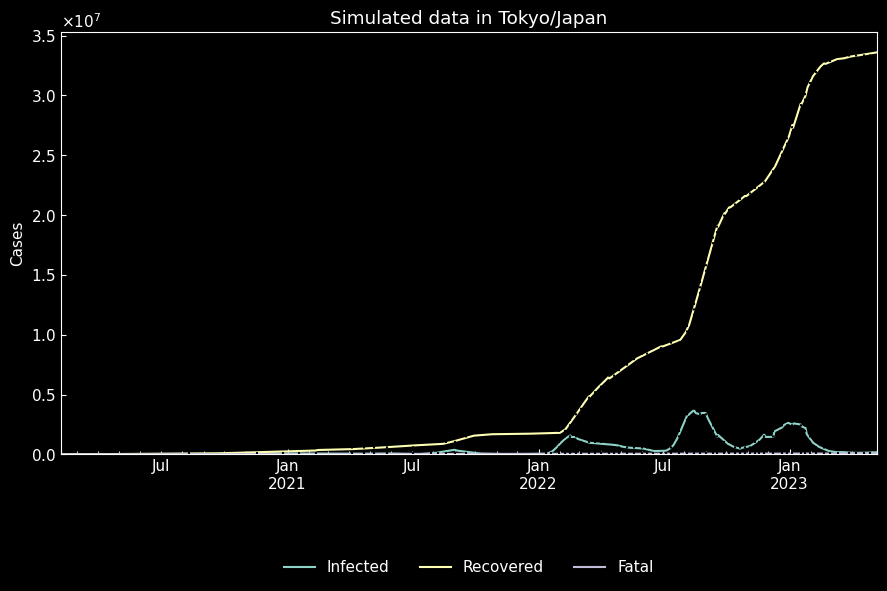

In [39]:
cs.line_plot(
    simulated_df.drop("Susceptible", axis=1),
    title="Simulated data in Tokyo/Japan",
    v=dyn_act.start_dates()[1:],
    bbox_to_anchor=(0.5, -0.3),
)

When we need to simulate for the last 30 days, we can use `Dynamics().parse_days(days=-30, ref="last")`.

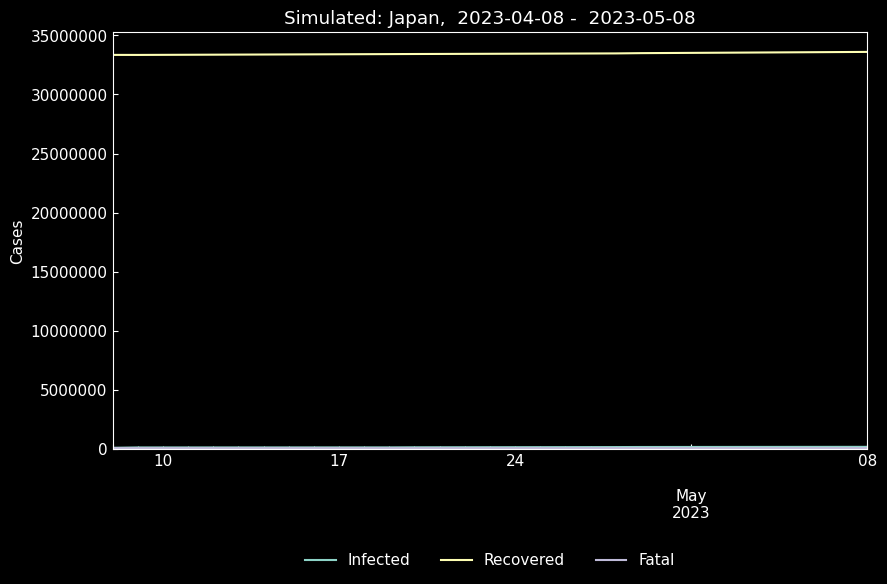

In [40]:
start, end = dyn_act.parse_days(days=-30, ref="last")
cs.line_plot(
    simulated_df.drop("Susceptible", axis=1).loc[start: end],
    title=f"Simulated: Japan, {start: %Y-%m-%d} - {end: %Y-%m-%d}",
    bbox_to_anchor=(0.5, -0.3),
    y_integer=True,
)

When we need to perform simulation for th 5th and 6th phase, We can use `Dynamics().parse_phases(phases=["5th", "6th"])`).

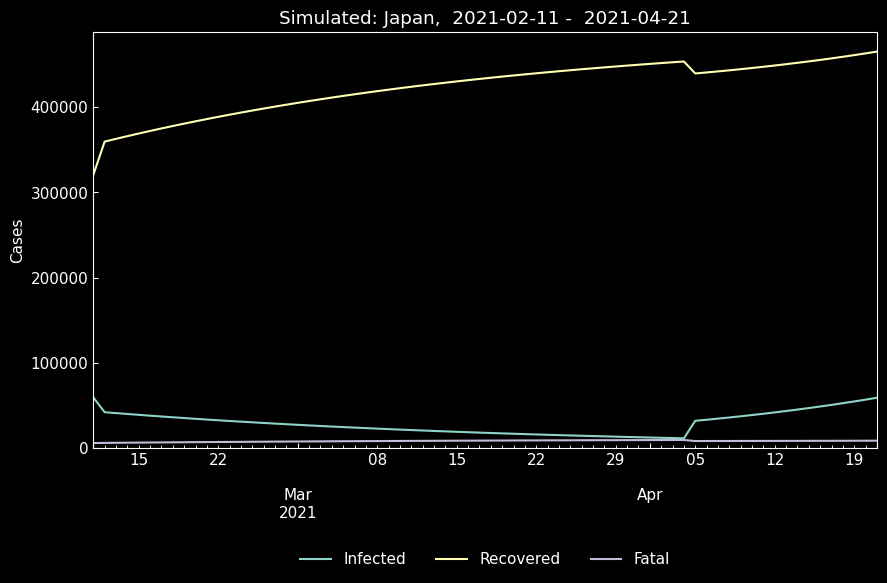

In [41]:
start, end = dyn_act.parse_phases(phases=["5th", "6th"])
cs.line_plot(
    simulated_df.drop("Susceptible", axis=1).loc[start: end],
    title=f"Simulated: Japan, {start: %Y-%m-%d} - {end: %Y-%m-%d}",
    bbox_to_anchor=(0.5, -0.3),
    y_integer=True,
)

### 4-6. Tracking of ODE parameters
Track the estimated ODE parameter values.

In [42]:
track_df = dyn_act.track()
track_df.tail()

,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Date,,,,,,,,,
2023-05-04,1.53,0.000391,0.000001,0.001086,0.00071,0.0,9781,10,15
2023-05-05,1.53,0.000391,0.000001,0.001086,0.00071,0.0,9781,10,15
2023-05-06,1.53,0.000391,0.000001,0.001086,0.00071,0.0,9781,10,15
2023-05-07,1.53,0.000391,0.000001,0.001086,0.00071,0.0,9781,10,15
2023-05-08,1.53,0.000391,0.000001,0.001086,0.00071,0.0,9781,10,15


In [43]:
track_df.columns

Index(['Rt', 'theta', 'kappa', 'rho', 'sigma', 'alpha1 [-]', '1/alpha2 [day]',
       '1/beta [day]', '1/gamma [day]'],
      dtype='object')

In [44]:
def history(param_name, title=None, h=None):
    """Display the history of ODE parameter values tracked with global `track_df`.
    
    Args:
        param_name (str): name of the parameter
        title (str or None): figure title or Nome (@param_name will be used)
        h (list/tuple[int/float] or None): list of y values of horizontal lines or None
    """
    global track_df
    cs.line_plot(
        track_df.loc[:, param_name],
        title=title or f"Tracked {param_name}",
        ylabel=param_name,
        math_scale=False,
        h=h,
        show_legend=False,
    )

$\theta$ and $\alpha_1$:  
Enhancement of PCR tests suppressed the number of fatal cases before confirmation.

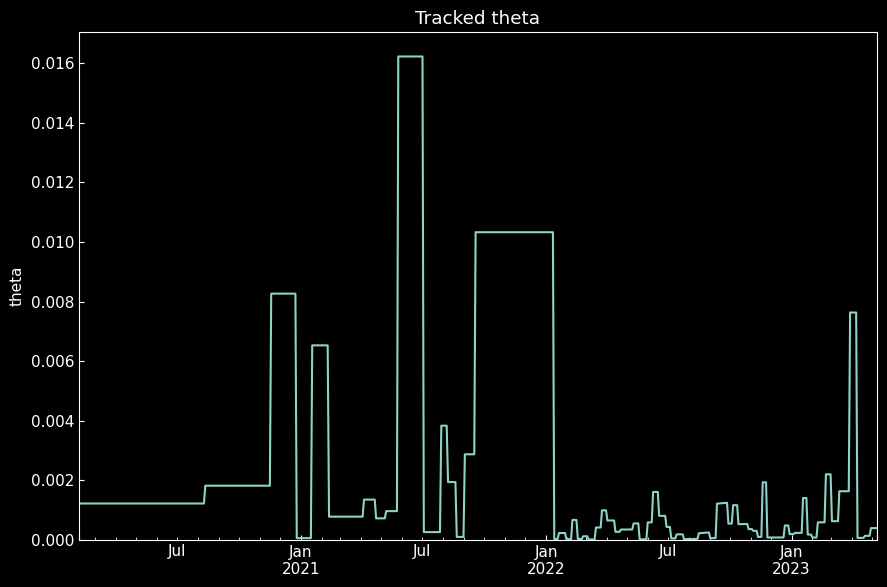

In [45]:
history("theta")

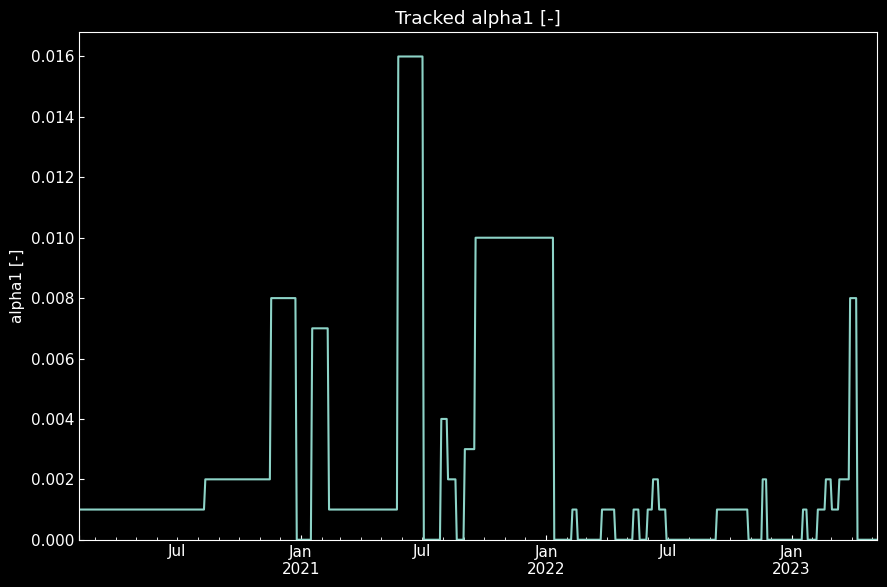

In [46]:
history("alpha1 [-]")

$\kappa$ and $1/\alpha_2$:  
Enhancement of medical system suppressed the number of fatal cases.

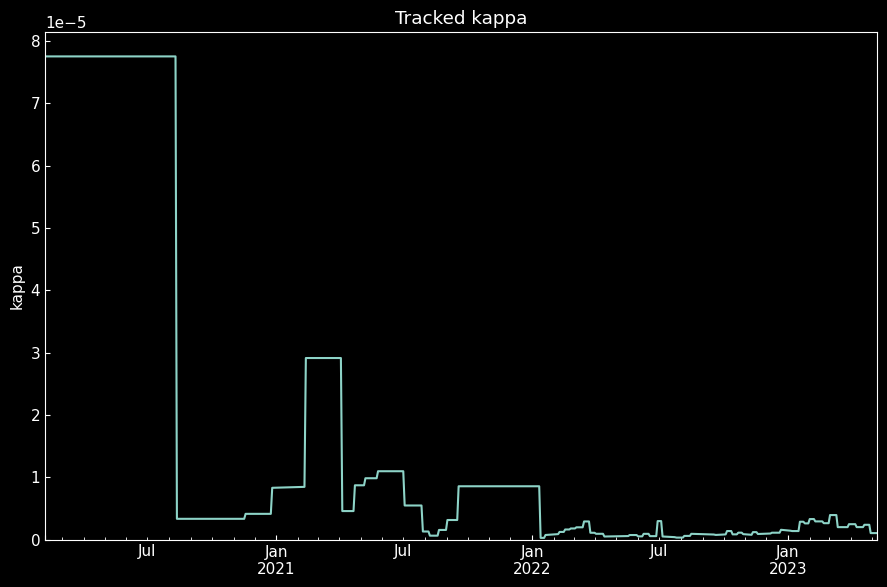

In [47]:
history("kappa")

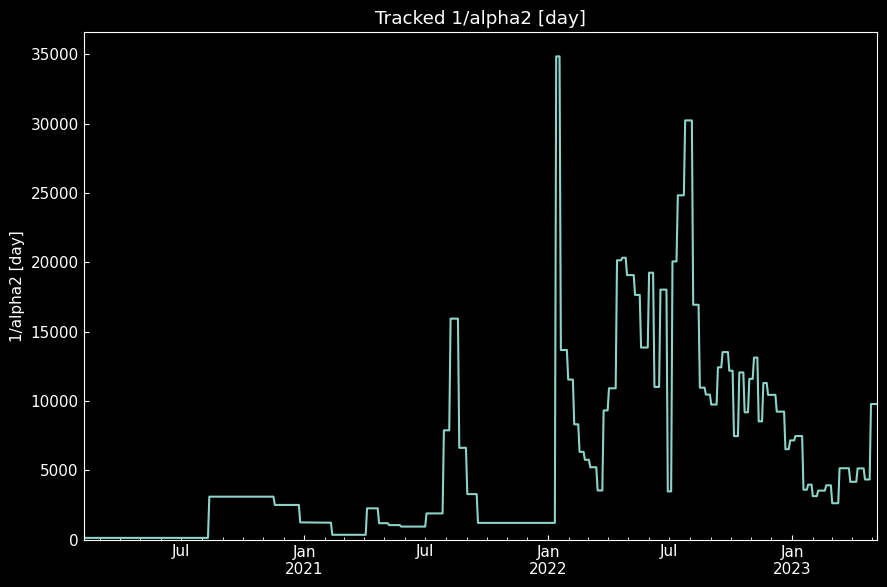

In [48]:
history("1/alpha2 [day]")

$\rho$ and $1/\beta$:  
Contact rate was changed with emergency declaration in Tokyo.

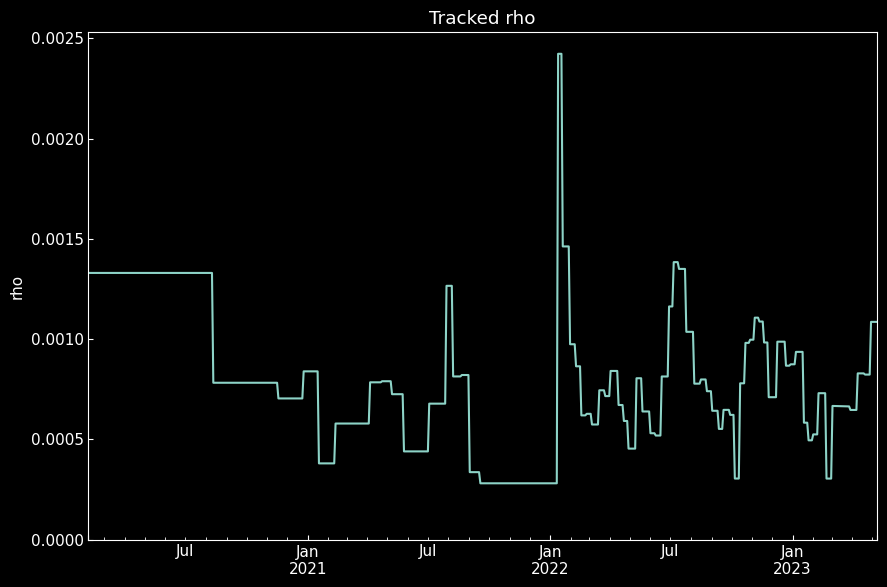

In [49]:
history("rho")

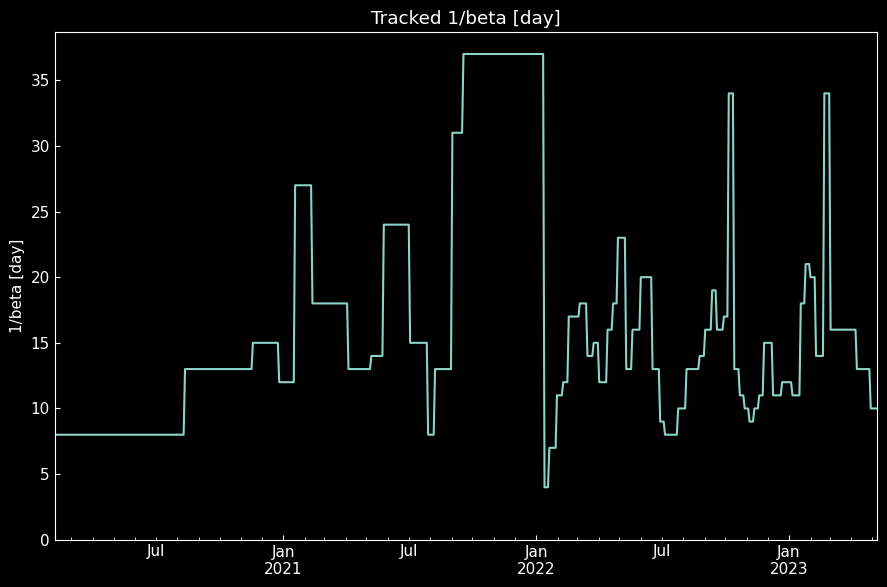

In [50]:
history("1/beta [day]")

$\sigma$ and $1/\gamma$:  
Recovery period is not changed clearly at this time.

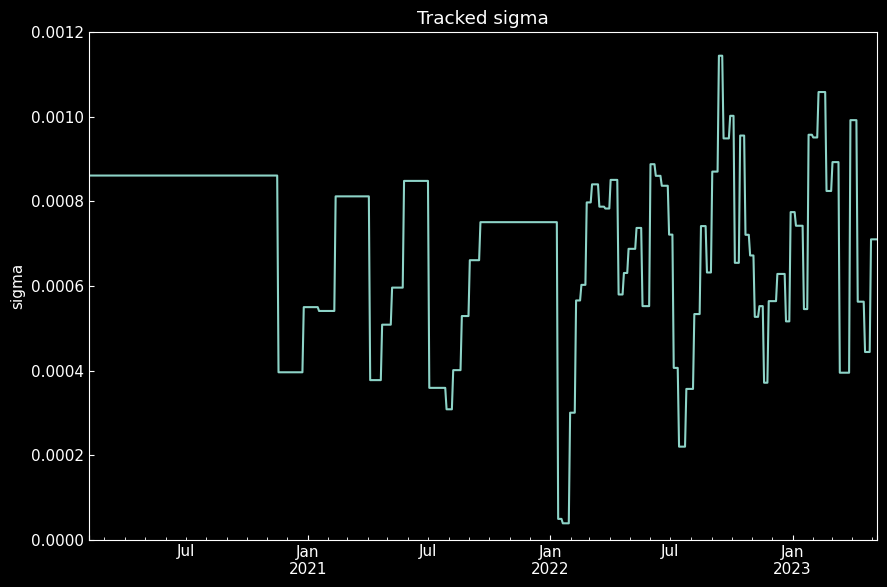

In [51]:
history("sigma")

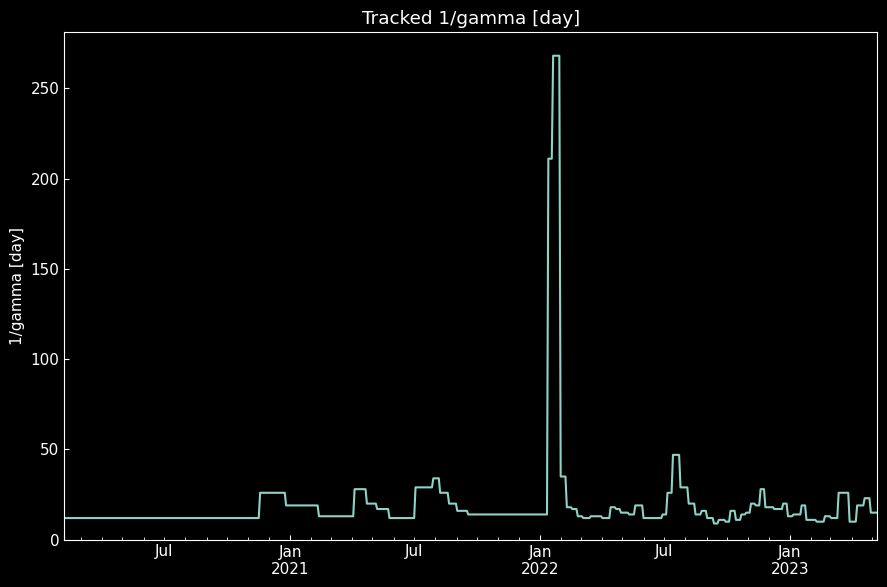

In [52]:
history("1/gamma [day]")

Reproduction number:  
Rt > 1 means explosive outbreak.

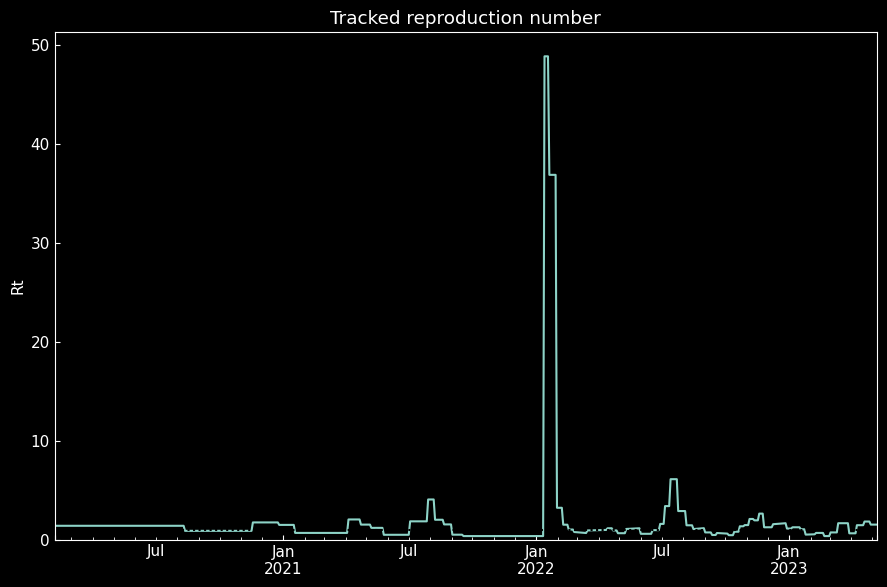

In [53]:
history("Rt", title="Tracked reproduction number", h=1.0)

Thank you!